In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [4]:
vectorizer_bigram = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b", ngram_range=(2, 2))
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bigram = vectorizer_bigram.fit_transform(list(s)).toarray()
df_bigram = pd.DataFrame(data = X_bigram, columns = vectorizer_bigram.get_feature_names())

# 2. SimHash

In [5]:
%%time
embeddings = simhash(df_bigram)
embeddings

CPU times: user 3.4 s, sys: 0 ns, total: 3.4 s
Wall time: 3.43 s


array([[1, 1, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 1, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 0]])

# 3. Locality Sensitive Hashing

In [6]:
size_vector = 8
max_permutation = int(embeddings.shape[1] / size_vector)

l = list(np.arange(max_permutation))
combinations = list(itertools.combinations(l, 3))
hash_tables = create_hash_tables_simhash(combinations, embeddings, size_vector)

In [7]:
index = 178
set_near_duplicates = near_duplicates_simhash(index, combinations, embeddings, size_vector, hash_tables)
set_near_duplicates

{29, 59, 83, 109, 142, 178, 234, 251, 394, 411, 609, 726, 813}

In [8]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [9]:
near_duplicates_sim = df_measures['Cosine-bigram'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

162301    0.928571
103073    0.857143
79608     0.857143
28713     0.857143
162703    0.815374
57348     0.785714
162124    0.785714
162284    0.785714
131882    0.785714
162616    0.785714
162141    0.785714
162499    0.714286
Name: Cosine-bigram, dtype: float64

In [10]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Cosine-bigram', n_stacks, n_duplicate_pairs)
set_real_nns

{29, 59, 83, 109, 114, 251, 326, 357, 394, 411, 813, 997}

In [11]:
real_nns_sim[:n_duplicate_pairs]

162301    0.928571
79608     0.857143
28713     0.857143
103073    0.857143
107508    0.815374
162887    0.815374
162703    0.815374
162216    0.815374
162247    0.785714
162141    0.785714
162284    0.785714
57348     0.785714
dtype: float64

# 4. Metrics (SimHash)

In [ ]:
df_probLSH = mean_prob_hashing_smallest_elt_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'Cosine-bigram', trace = False)

f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("permutations", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Cosine-bigram (SimHash) [Relation Prob-Sim]', fontsize = 16)
plt.show()

## 4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [29]:
'All params'
k_first_positions = 1
recal_rate_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'Cosine-bigram', k_first_positions)

0.58

In [ ]:
'Best param'
k_first_positions = 1
recal_rate_one_param_simhash (n_stacks, 4, embeddings, size_vector, df_measures, 'Cosine-bigram', k_first_positions)

-----------------------------------------------------------------

In [30]:
'All params'
k_first_positions = 3
recal_rate_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'Cosine-bigram', k_first_positions)

0.5923333333333337

In [ ]:
'Best param'
k_first_positions = 3
recal_rate_one_param_simhash (n_stacks, 4, embeddings, size_vector, df_measures, 'Cosine-bigram', k_first_positions)

-----------------------------------------------------------------

In [31]:
'All params'
k_first_positions = 5
recal_rate_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'Cosine-bigram', k_first_positions)

0.5791999999999998

In [ ]:
'Best param'
k_first_positions = 5
recal_rate_one_param_simhash (n_stacks, 4, embeddings, size_vector, df_measures, 'Cosine-bigram', k_first_positions)

## 4.2. Generalized MRR

In [32]:
df_knns = mean_generalized_mrr_simhash (n_stacks, max_permutation, embeddings, size_vector, df_measures, 'Cosine-bigram', trace = False)
df_knns.mean(skipna = True, axis = 0).mean()

0.7953222010124372

## 4.3. Recall w.r.t. LSH

In [12]:
df_recall = recall_all_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures , 'Cosine-bigram', trace = False)
df_recall.mean(skipna = True)

8    1.000000
7    0.075163
6    0.121683
5    0.228993
4    0.279796
3    0.411388
2    0.596769
1    0.802953
dtype: float64

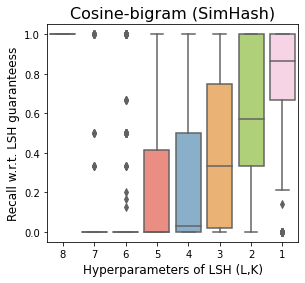

In [13]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Recall w.r.t. LSH guaranteess", fontsize = 12)
plt.title('Cosine-bigram (SimHash)', fontsize = 16)
plt.savefig('Results/SimHash/Recall-LSH', bbox_inches='tight')
plt.show()

## 4.4. Precision w.r.t. LSH

In [14]:
df_precision = precision_all_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures , 'Cosine-bigram', trace = False)
df_precision.mean(skipna = True, axis = 0)

8    0.857143
7    0.588235
6    0.714461
5    0.640698
4    0.788235
3    0.663029
2    0.389879
1    0.132097
dtype: float64

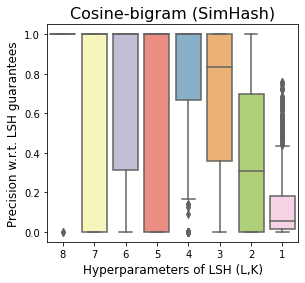

In [15]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 12)
plt.title('Cosine-bigram (SimHash)', fontsize = 16)
plt.savefig('Results/SimHash/precision-LSH', bbox_inches='tight')
plt.show()

## 4.5. Fscore w.r.t. LSH

In [18]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

8    0.857143
7    0.078616
6    0.123254
5    0.216271
4    0.284087
3    0.379141
2    0.355070
1    0.187000
dtype: float64

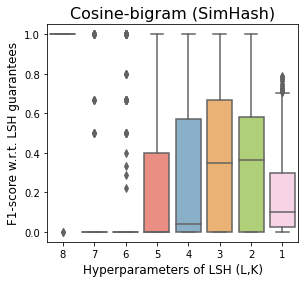

In [17]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 12)
plt.title('Cosine-bigram (SimHash)', fontsize = 16)
plt.savefig('Results/SimHash/fscore-LSH', bbox_inches='tight')
plt.show()